In [1]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [2]:
#Uncomment to install ydata-synthetic lib
#! pip install ydata-synthetic

In [19]:
# extract data
from epftoolbox.data import read_data

In [20]:
from epftoolbox.evaluation import MAE
from epftoolbox.evaluation import RMSE
from epftoolbox.evaluation import MAPE
from epftoolbox.evaluation import sMAPE
from epftoolbox.evaluation import MASE
from epftoolbox.evaluation import rMAE
# calculating rMAE and MASE require naive forecast

In [21]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [22]:
#Specific to TimeGANs
seq_len=24
n_seq = 3
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [23]:
stock_data = processed_stock(path='../../examples/timeseries/FR.csv', seq_len=seq_len)
print(len(stock_data),stock_data[0].shape)

52392 (24, 3)


In [24]:
df_train, df_test = read_data(path='.', dataset='FR', begin_test_date='01-09-2016',end_test_date='12-31-2016')

Test datasets: 2016-09-01 00:00:00 - 2016-12-31 23:00:00


/Users/nasifrahman/opt/anaconda3/envs/synth-env/lib/python3.9/site-packages/epftoolbox/data/_datasets.py:147: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  end_test_date = pd.to_datetime(end_test_date, dayfirst=True)


In [25]:
# train dataset
df_train

Price  Exogenous 1  Exogenous 2
Date                                                 
2011-01-09 00:00:00  32.542      63065.0      63000.0
2011-01-09 01:00:00  21.549      62715.0      58800.0
2011-01-09 02:00:00  15.711      61952.0      58500.0
2011-01-09 03:00:00  10.583      59262.0      54300.0
2011-01-09 04:00:00  10.324      56883.0      51900.0
...                     ...          ...          ...
2016-08-31 19:00:00  45.660      49371.0      51870.0
2016-08-31 20:00:00  45.650      48961.0      50205.0
2016-08-31 21:00:00  45.820      49125.0      50578.0
2016-08-31 22:00:00  43.000      48221.0      47560.0
2016-08-31 23:00:00  38.060      47371.0      50619.0

[49488 rows x 3 columns]

In [26]:
date = df_train.index

In [27]:
price = df_train['Price']

In [28]:
price

Date
2011-01-09 00:00:00    32.542
2011-01-09 01:00:00    21.549
2011-01-09 02:00:00    15.711
2011-01-09 03:00:00    10.583
2011-01-09 04:00:00    10.324
                        ...  
2016-08-31 19:00:00    45.660
2016-08-31 20:00:00    45.650
2016-08-31 21:00:00    45.820
2016-08-31 22:00:00    43.000
2016-08-31 23:00:00    38.060
Name: Price, Length: 49488, dtype: float64

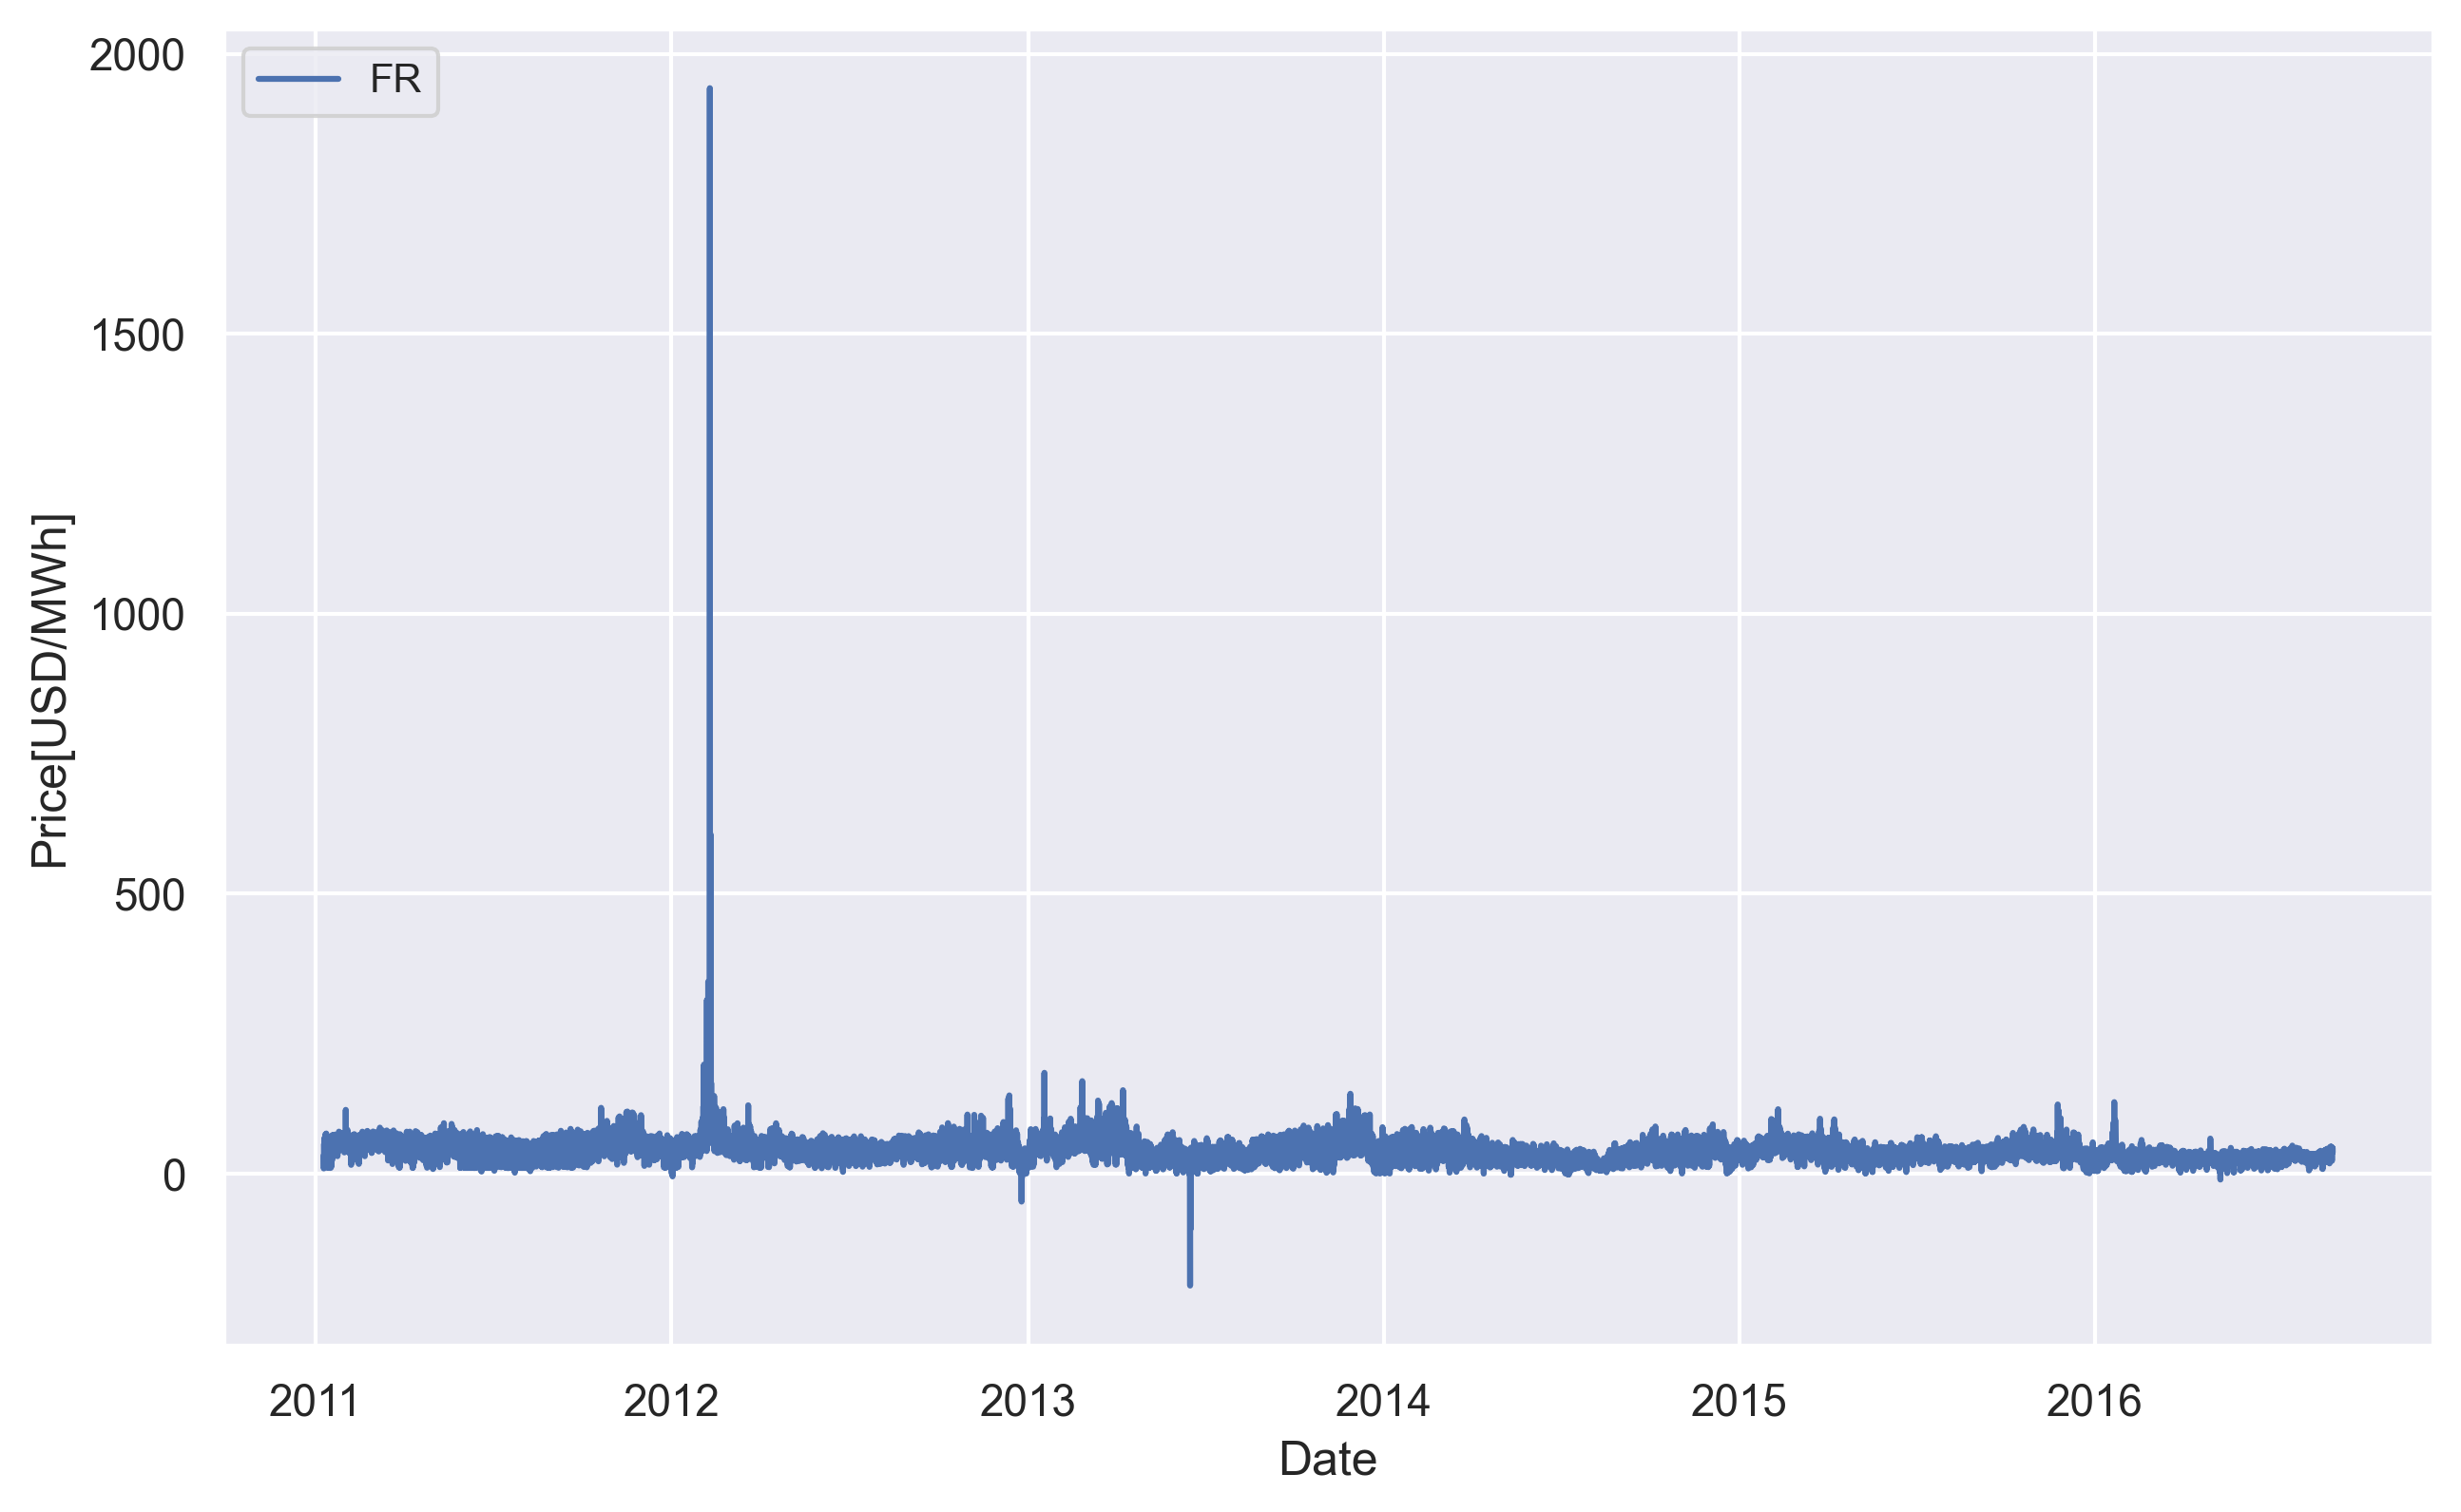

In [29]:
import seaborn as sns
sns.set()
#figu, ax = plt.subplots(nrows =1, ncols=1, figsize = (10,6))
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize = (10,6))
plt.plot(price)

plt.legend(loc = 'upper left',fontsize = 'small',labels=["FR"])
plt.xlabel("Date")
plt.ylabel("Price[USD/MWh]")
plt.show()

In [180]:
print(df_train.shape)
print(df_test.shape)

(49488, 3)
(2928, 3)


In [181]:
#elect_data = processed_stock(path='../AMS 522/PJM.csv', seq_len=seq_len)
#print(len(elect_data),elect_data[0].shape)

## Training the TimeGAN synthetizer

In [33]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=50000)
    synth.save('synthesizer_stock.pkl')

### The generated synthetic stock data

In [35]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████████| 410/410 [00:54<00:00,  7.55it/s]

(52480, 24, 3)


In [53]:
# for j, col in enumerate(cols):
#     print(j, col)

np.random.randint(len(stock_data))

23469

In [54]:
synth_data.shape

(52480, 24, 3)

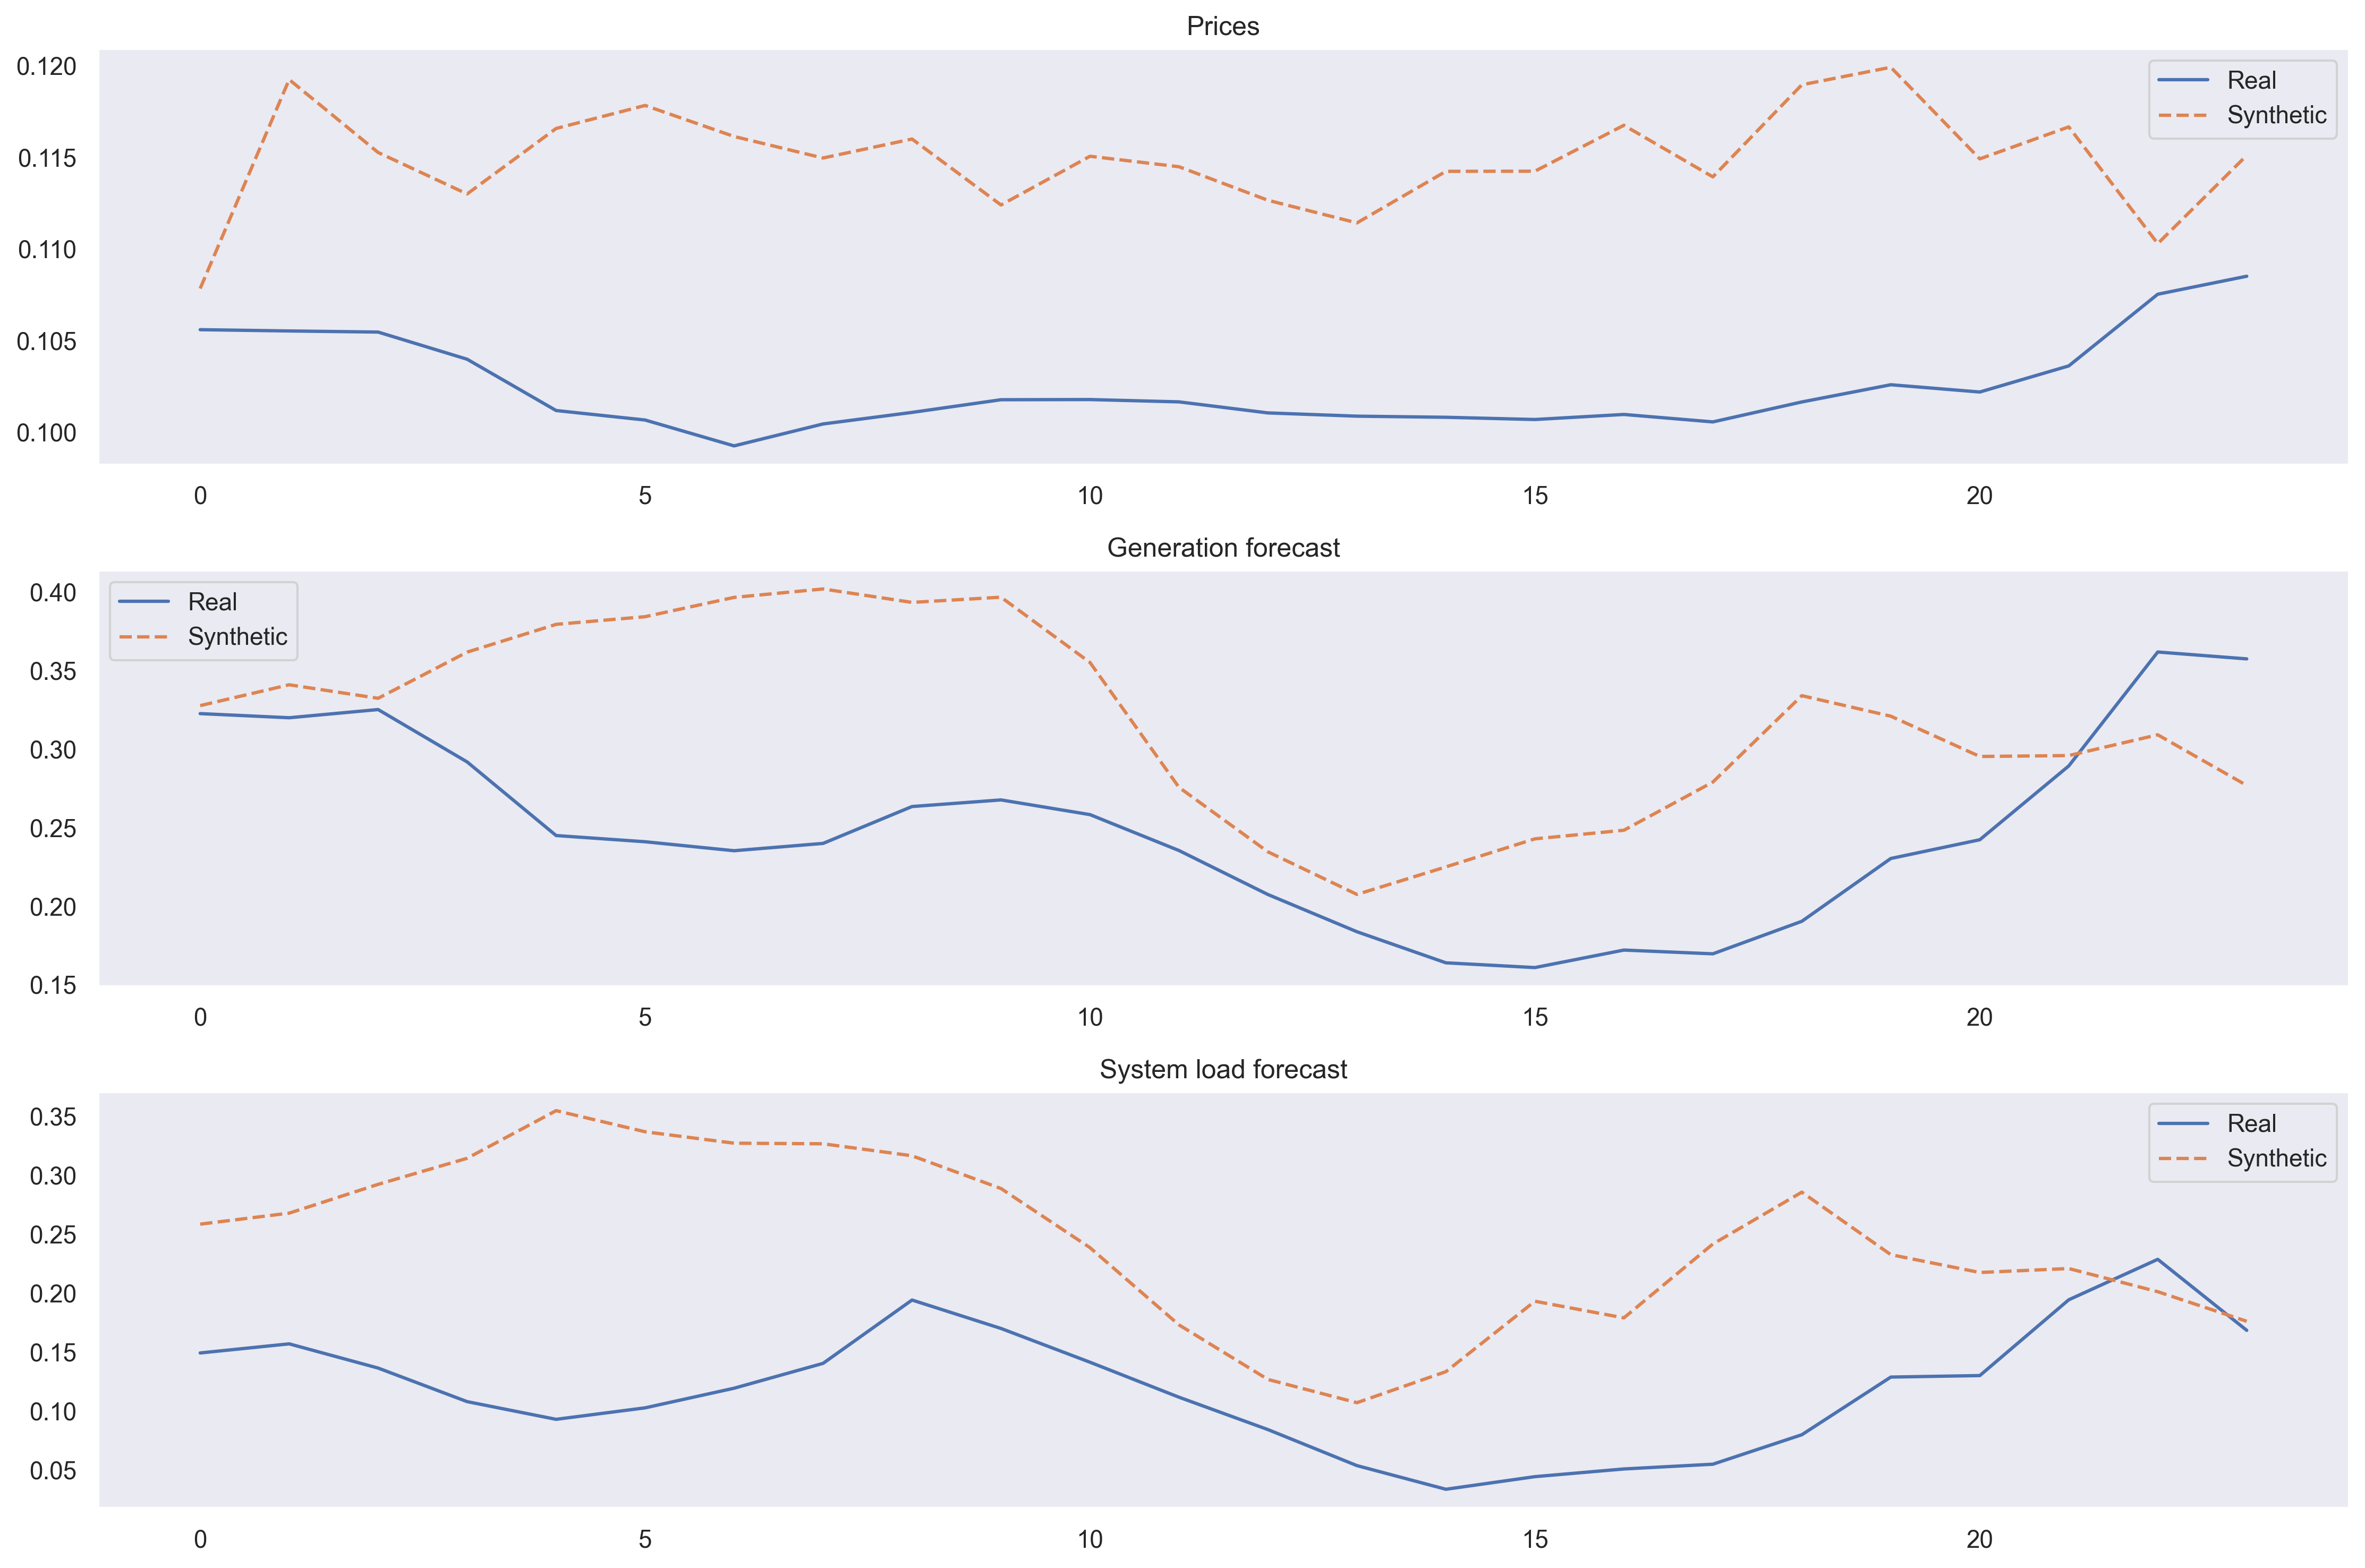

In [58]:
#Reshaping the data
cols = ['Prices', 'Generation forecast', 'System load forecast']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [59]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

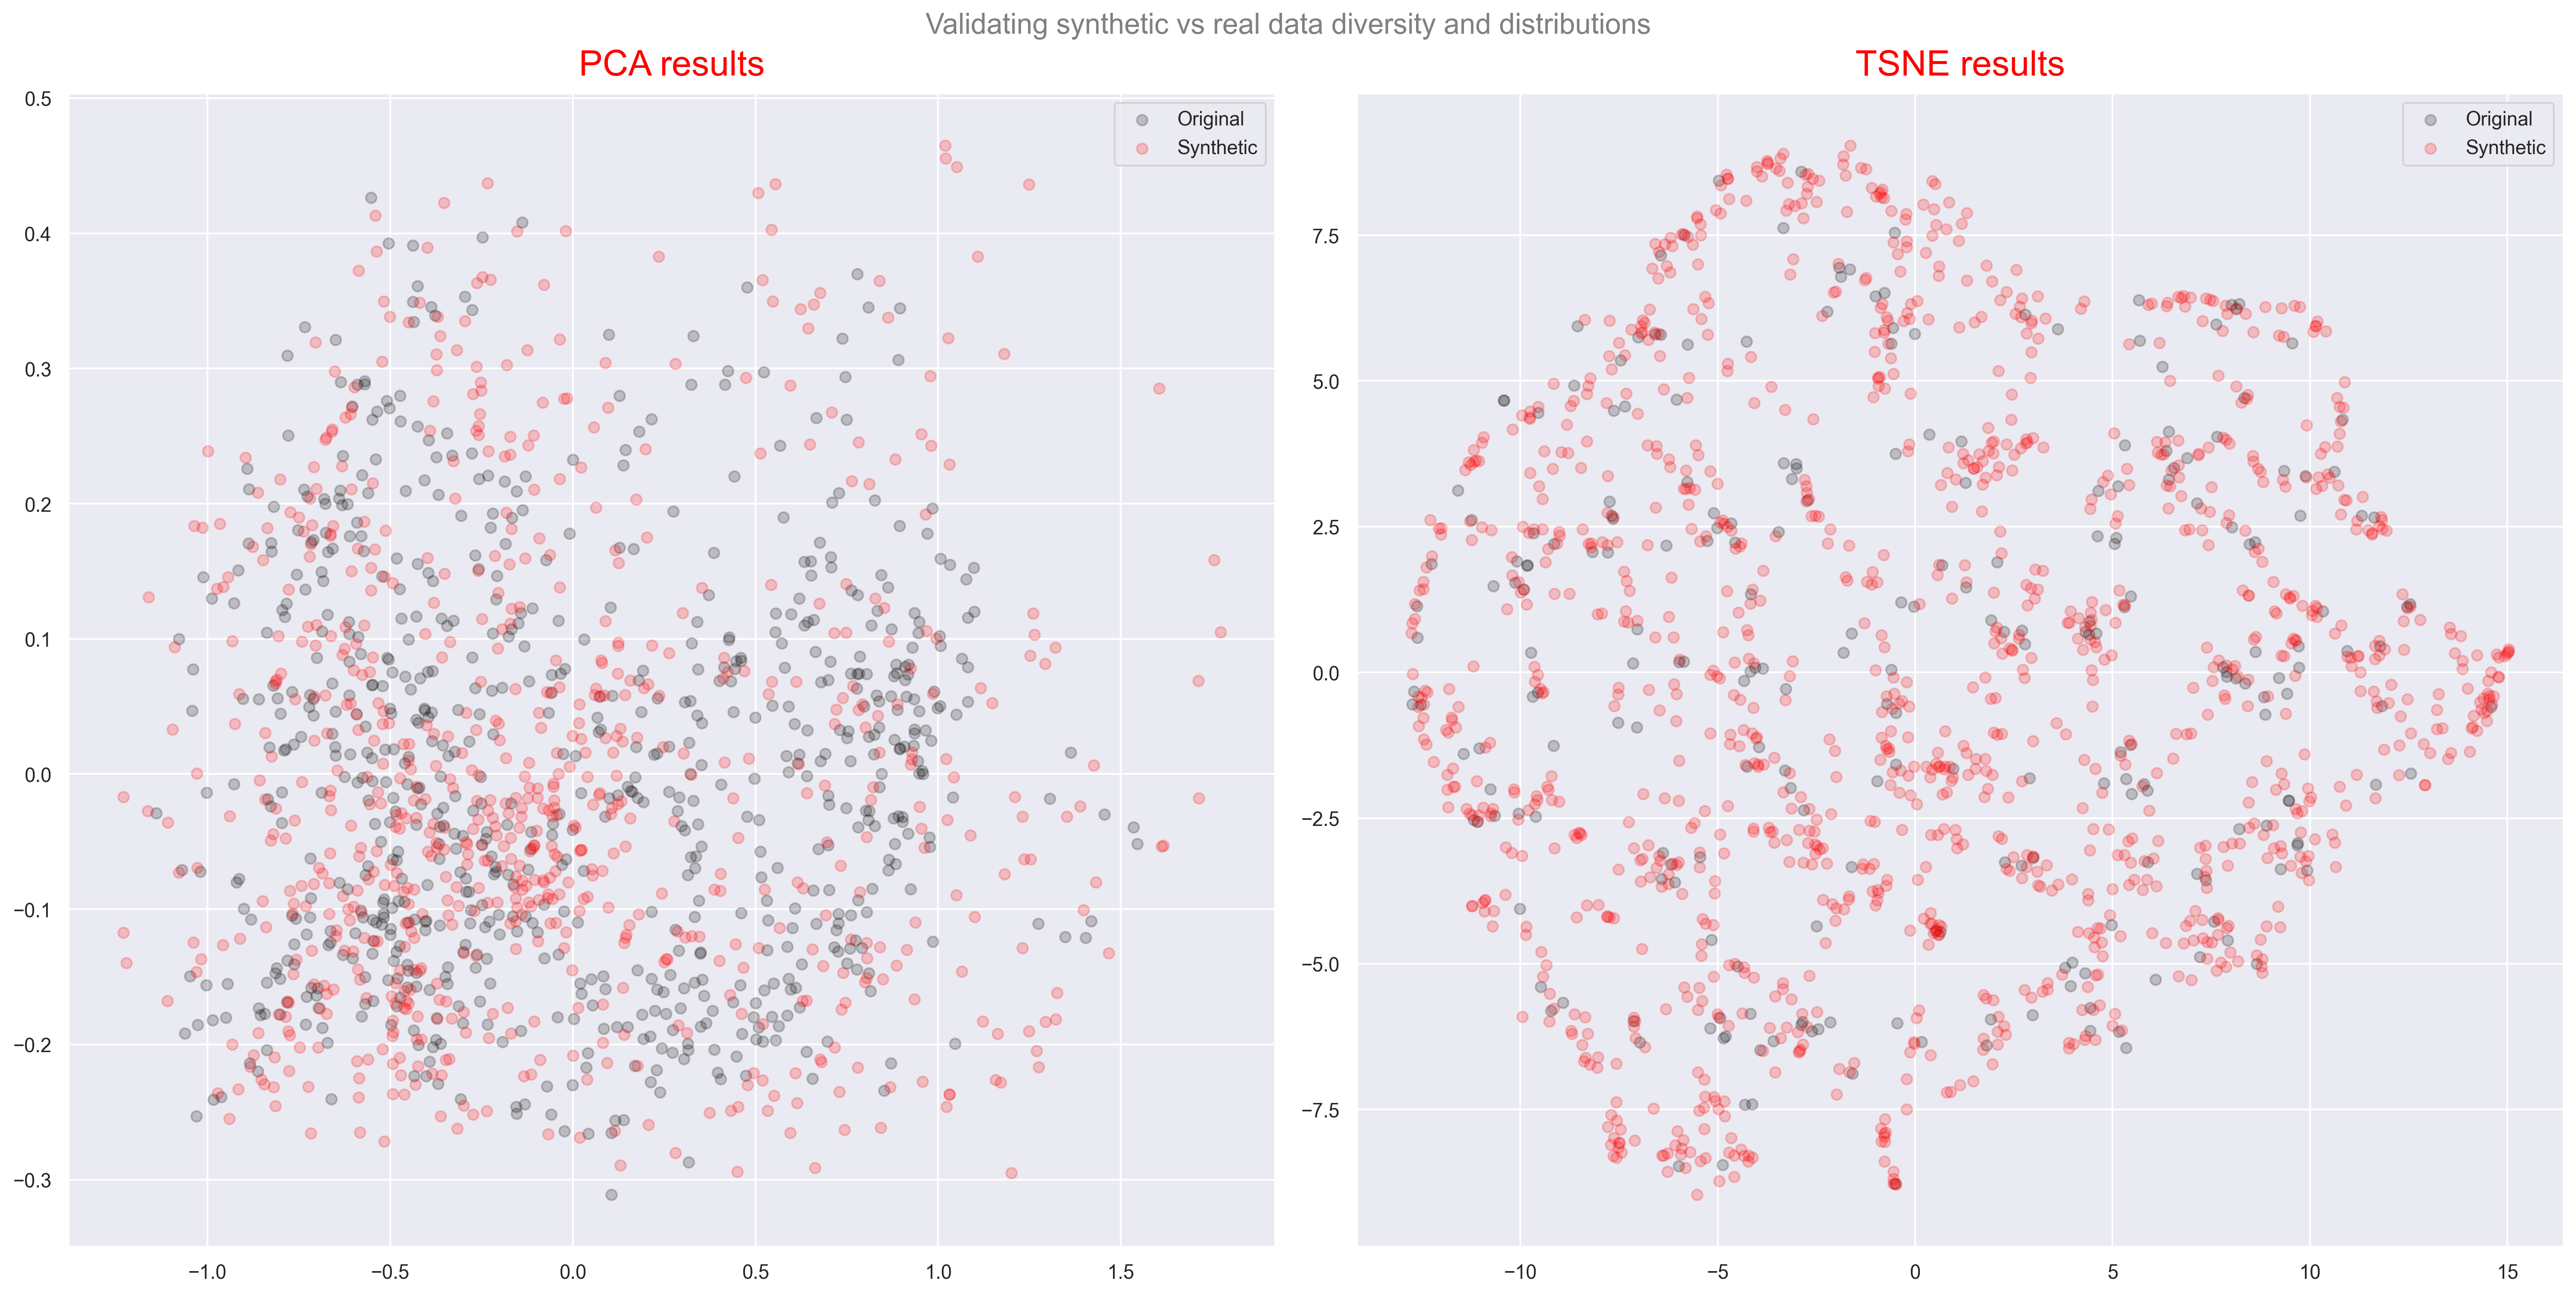

In [182]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

In [61]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=3,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [137]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
stock_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.750343564*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (39312, 23, 3)
Real X train: (39312, 23, 3)
Synthetic y train: (39312, 3)
Real y train: (39312, 3)
Real X test: (13080, 23, 3)
Real y test: (13080, 3)


In [138]:
X_stock_train2 = stock_data[train_idx,-1, :]
X_synth_train2 = synth_data[train_idx,-1,:]

In [139]:
X_stock_train2.shape

(39312, 3)

In [140]:
X_stock_train2

array([[0.09577566, 0.7094089 , 0.54463106],
       [0.10397137, 0.19055802, 0.13897817],
       [0.10930072, 0.6976813 , 0.49589154],
       ...,
       [0.09613271, 0.6565394 , 0.55588317],
       [0.1142271 , 0.32061788, 0.18439302],
       [0.11029334, 0.19748223, 0.14179258]], dtype=float32)

In [141]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
308/308 [==============================] - 3s 5ms/step - loss: 0.0878 - val_loss: 0.0338
Epoch 2/200
308/308 [==============================] - 1s 5ms/step - loss: 0.0325 - val_loss: 0.0309


In [142]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
308/308 [==============================] - 3s 6ms/step - loss: 0.0924 - val_loss: 0.0326
Epoch 2/200
308/308 [==============================] - 2s 5ms/step - loss: 0.0309 - val_loss: 0.0292


In [143]:
# predictions
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

409/409 [==============================] - 0s 809us/step


In [144]:
# take only price data
real_predictions

array([[0.1111323 , 0.3166309 , 0.2328994 ],
       [0.11538194, 0.63079506, 0.5591073 ],
       [0.11474264, 0.63133997, 0.5469075 ],
       ...,
       [0.119098  , 0.5133645 , 0.440332  ],
       [0.11309668, 0.24117486, 0.17946409],
       [0.11063682, 0.24420689, 0.17811215]], dtype=float32)

In [145]:
# price array for real_prediction
r_pred = real_predictions.flatten()
re_pred = r_pred[0:len(r_pred):3]

In [146]:
re_pred.shape

(13080,)

In [147]:
# price array for synthetic data
s_pred = synth_predictions.flatten()
sy_pred = s_pred[0:len(s_pred):3]

In [148]:
sy_pred.shape

(13080,)

In [149]:
y_stock_test

array([[0.11734298, 0.24211456, 0.16345713],
       [0.13213277, 0.6334214 , 0.5609073 ],
       [0.09729648, 0.6956381 , 0.49000502],
       ...,
       [0.10103162, 0.42575833, 0.3967594 ],
       [0.10907588, 0.16090621, 0.12073454],
       [0.10455777, 0.3056745 , 0.20594747]], dtype=float32)

In [150]:
# price data for y_stock_test
y_st = y_stock_test.flatten()
y_stock = y_st[0:len(y_st):3]
y_stock[:10]

array([0.11734298, 0.13213277, 0.09729648, 0.11708561, 0.09854497,
       0.09520247, 0.12607098, 0.11231318, 0.11548451, 0.12650612],
      dtype=float32)

In [151]:
y_stock_train

array([[0.09577566, 0.7094089 , 0.54463106],
       [0.10397137, 0.19055802, 0.13897817],
       [0.10930072, 0.6976813 , 0.49589154],
       ...,
       [0.09613271, 0.6565394 , 0.55588317],
       [0.1142271 , 0.32061788, 0.18439302],
       [0.11029334, 0.19748223, 0.14179258]], dtype=float32)

In [152]:
y_s = y_stock_train.flatten()
y_ss = y_s[0:len(y_stock_train):3]

In [153]:
# MASE in-sample data check on it

In [154]:
#Summarize the metrics here as a pandas dataframe
metrics_dict = {'MAE': [MAE(y_stock, re_pred),
                        MAE(y_stock, sy_pred)],
                'rMAE':[rMAE(y_stock, re_pred, m ='D',freq='1H'),
                        rMAE(y_stock, sy_pred,m='D',freq='1H')],
                'MAPE':[MAPE(y_stock, re_pred),
                       MAPE(y_stock, sy_pred)],
                'sMAPE':[sMAPE(y_stock, re_pred),
                        sMAPE(y_stock, sy_pred)],
                'MASE': [MASE(y_stock, re_pred, X_stock_train2,m='D',freq='1H'),
                         MASE(y_stock, sy_pred, X_synth_train2,m='D',freq='1H')],
               'RMSE':[RMSE(y_stock,re_pred),
                      RMSE(y_stock, sy_pred)]
               }

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results


MAE      rMAE      MAPE     sMAPE      MASE      RMSE
Real       0.006365  0.755333  0.056983  0.056455  0.048787  0.008258
Synthetic  0.005854  0.694710  0.053365  0.051860  0.044871  0.007735

In [155]:
y_stock

array([0.11734298, 0.13213277, 0.09729648, ..., 0.10103162, 0.10907588,
       0.10455777], dtype=float32)

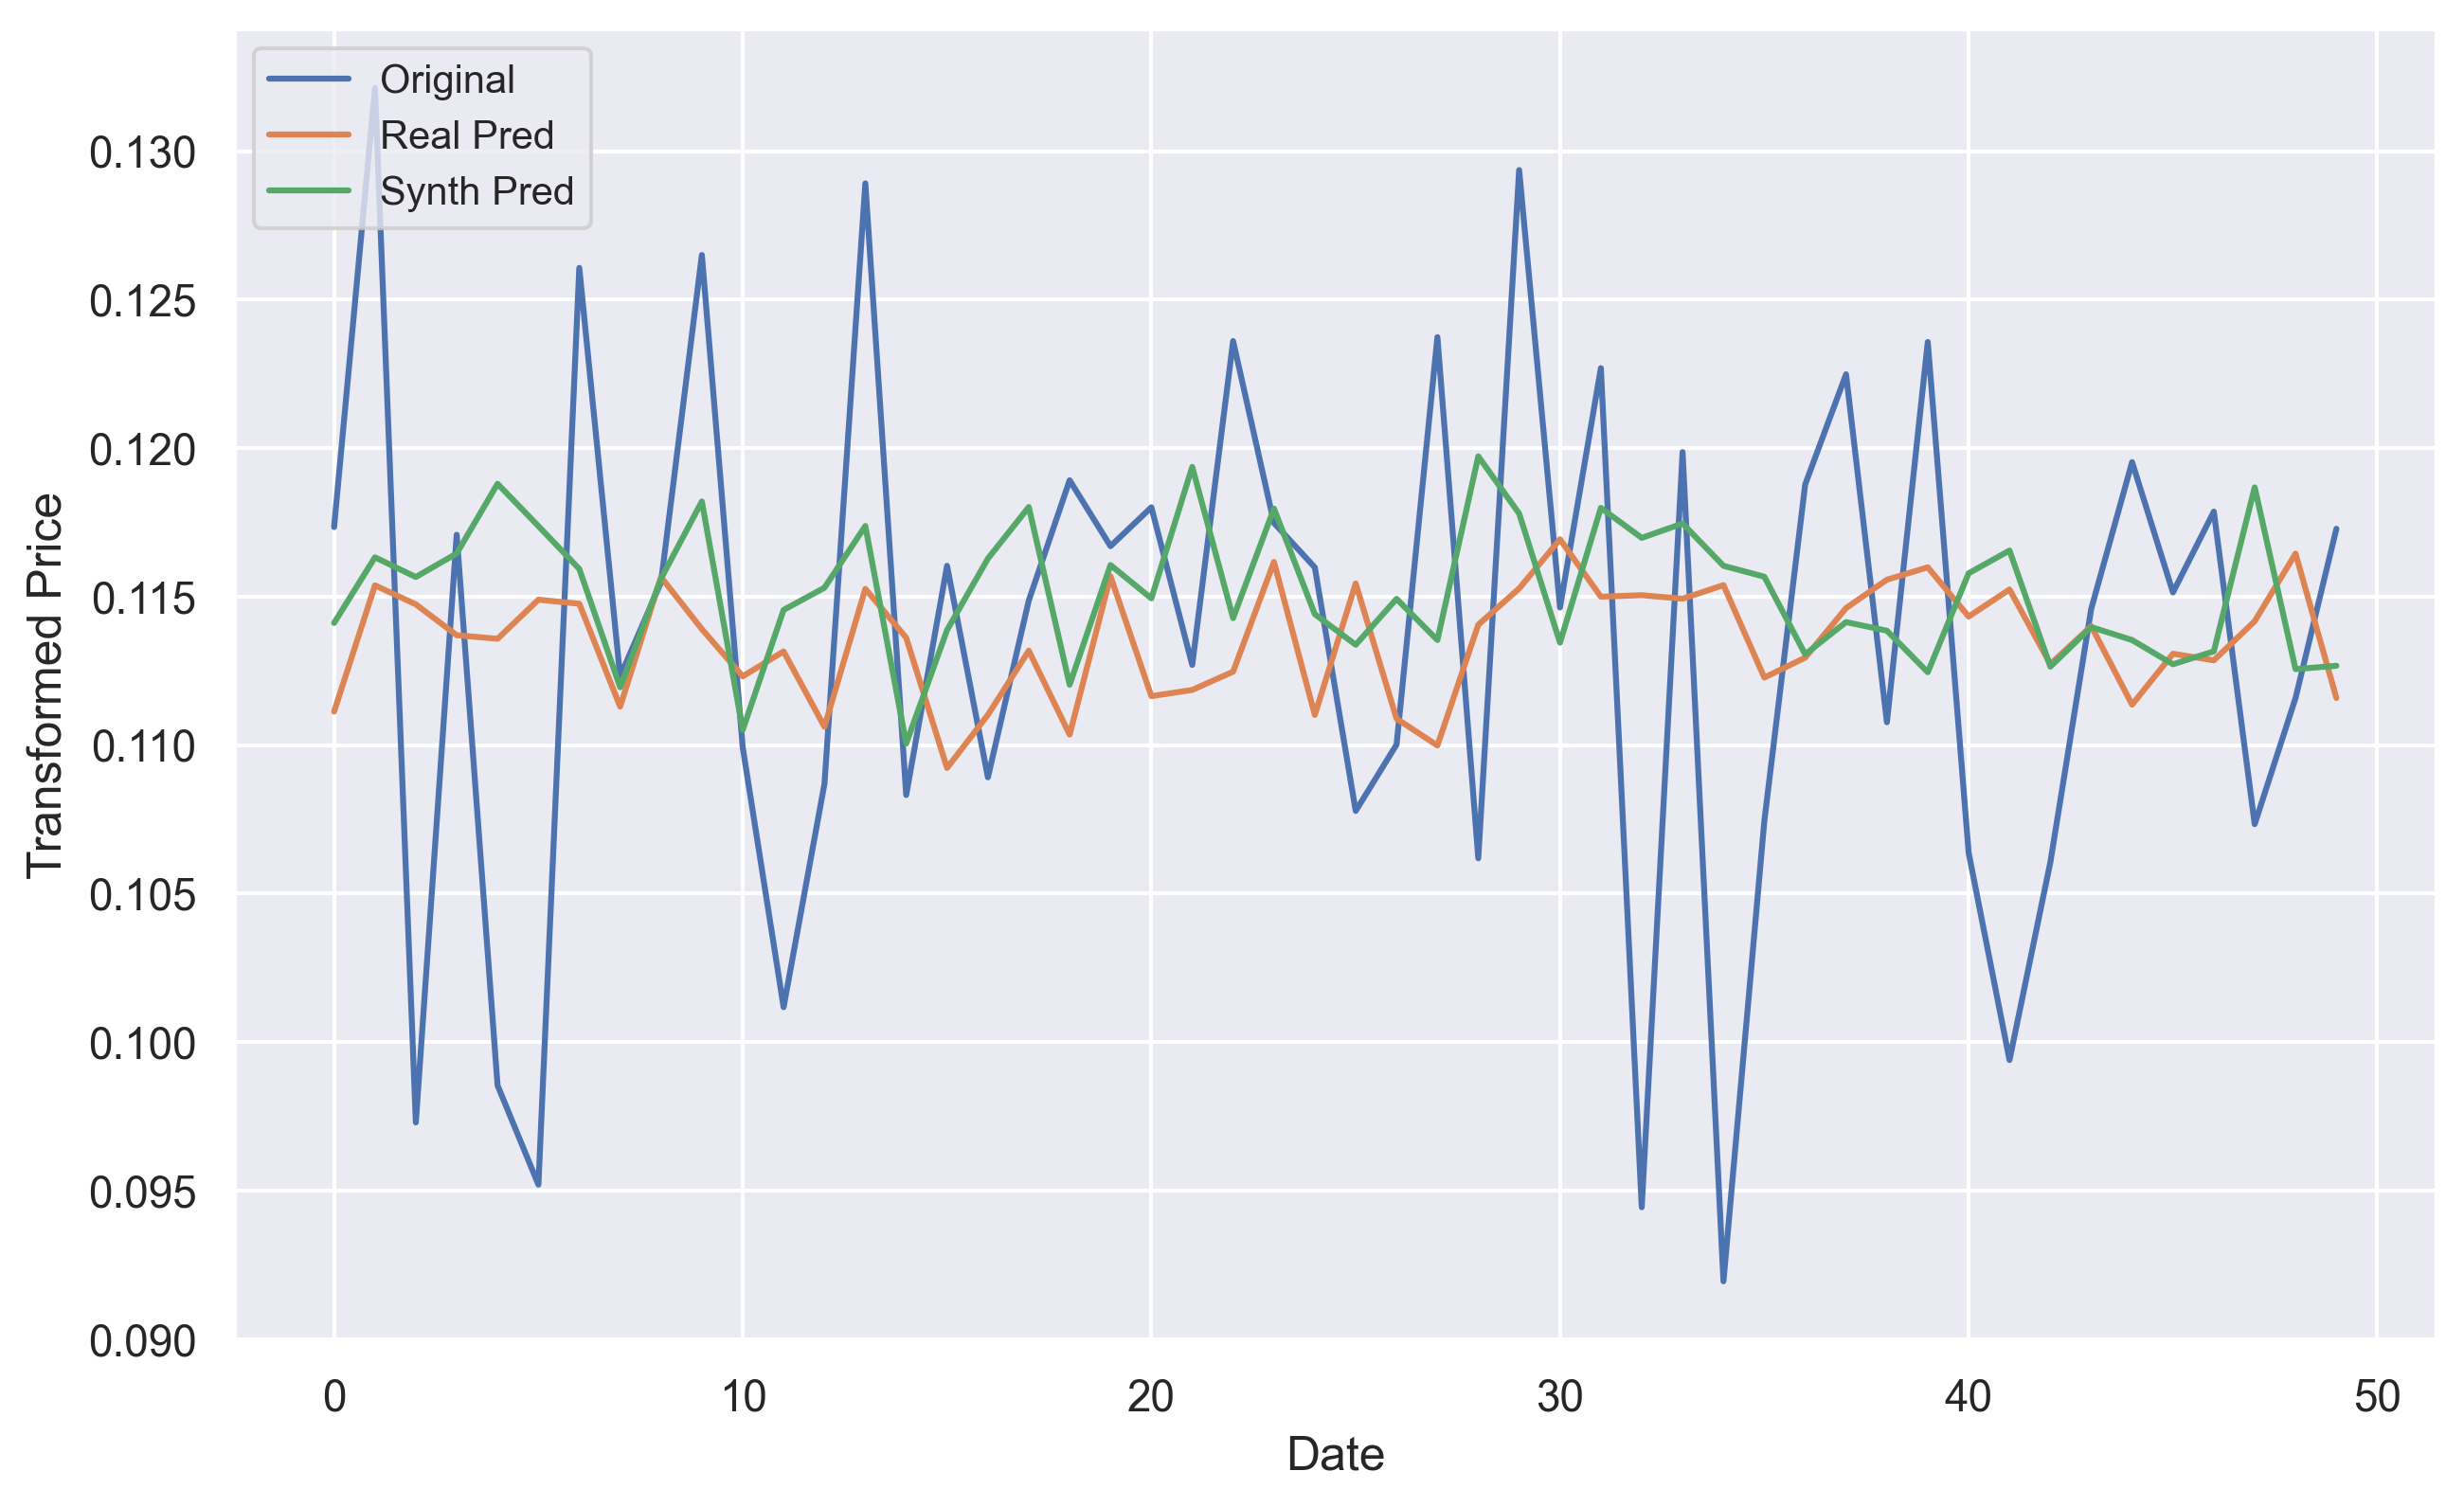

In [162]:
#figu, ax = plt.subplots(nrows =1, ncols=1, figsize = (10,6))
plt.rcParams['figure.dpi'] = 300

plt.figure(figsize = (10,6))
plt.plot(y_stock[:50])
plt.plot(re_pred[:50])
plt.plot(sy_pred[:50])


plt.legend(loc = 'upper left',fontsize = 'small',labels=["Original","Real Pred", "Synth Pred"])
plt.xlabel("Date")
plt.ylabel("Transformed Price")
plt.show()

In [1]:
from terminaltables import AsciiTable
data = [['Metrics','Best DNN', 'Best LEAR', 'TimeGAN Real', 'TimeGAN Synth'],['rMAE',0.554,0.580,0.75533,0.69471], ['MAE',4.063,4.250,0.0063653,0.005854 ],['MAPE [%]',14.284,14.896,0.056983*100,0.053365*100],['sMAPE [%]',11.488,13.250,0.056455*100,0.051860*100],['MASE','N/A','N/A',0.048787,0.044871],['RMSE', 11.880,10.759,0.008258,0.007735 ]]

In [2]:
table = AsciiTable(data, title='FR')
table.justify = 'center'
table.inner_row_border = True
print(table.table)

+FR---------+----------+-----------+--------------+---------------+
| Metrics   | Best DNN | Best LEAR | TimeGAN Real | TimeGAN Synth |
+-----------+----------+-----------+--------------+---------------+
| rMAE      | 0.554    | 0.58      | 0.75533      | 0.69471       |
+-----------+----------+-----------+--------------+---------------+
| MAE       | 4.063    | 4.25      | 0.0063653    | 0.005854      |
+-----------+----------+-----------+--------------+---------------+
| MAPE [%]  | 14.284   | 14.896    | 5.6983       | 5.3365        |
+-----------+----------+-----------+--------------+---------------+
| sMAPE [%] | 11.488   | 13.25     | 5.6455       | 5.186         |
+-----------+----------+-----------+--------------+---------------+
| MASE      | N/A      | N/A       | 0.048787     | 0.044871      |
+-----------+----------+-----------+--------------+---------------+
| RMSE      | 11.88    | 10.759    | 0.008258     | 0.007735      |
+-----------+----------+-----------+------------